In [3]:
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Name: Jonah Zembower
# Date: March 11, 2025
# Project: EY 2025 Data Science Challenge
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Introduction:

The model was similarly accurate for the random forest regressor and the XGBoost. Let's now try Light GBM.

# Libraries and Data:

Importing necessary libraries:

In [4]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For the geodataframe
import geopandas as gpd
from shapely import wkt
from scipy.spatial import cKDTree

# LightGBM Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial import cKDTree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor

Importing data:

In [5]:
# Satellite Data:
all_bands_granular = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_granular.csv")
all_bands_noisy_proximity = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_noisy_proximity.csv")
all_bands_proximity_noisy = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_proximity_noisy.csv")
all_bands_proximity_rounded_3 = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_proximity_rounded_3.csv")
all_bands_proximity_rounded_3_mapped = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_proximity_rounded_3_mapped.csv")
indices_granular = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\indices_granular.csv")
landsat_thermal_granular = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\landsat_thermal_granular.csv")
noisy_long_lat_uhi = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\noisy_long_lat_uhi.csv")

In [6]:
# Elevation Data:
all_elevation_nyc = pd.read_csv("C:\\Users\\jrzem\OneDrive\\Desktop\\EY Dataset\\Elevation\\all_elevation_nyc.csv")

In [7]:
# Load the test data
test_data = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Submission_template.csv")

# Light GBM Model:

1. sentinel (BO1, BO6 proximity) and elevation (building height only and natural elevation proximity)

In [8]:
# Add the landsat_thermal_granular data to the all_bands_proximity_rounded_3_mapped data
all_bands_elevation_2 = all_bands_proximity_rounded_3_mapped.merge(all_elevation_nyc[['Longitude', 'Latitude', 'Building Height Only Proximity','Natural Proximity']], on=['Longitude', 'Latitude'])
all_bands_elevation_2

# Save to CSV
all_bands_elevation_2.to_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_elevation_2.csv", index=False)

# Load dataset
all_bands_elevation_2 = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_elevation_2.csv")

In [9]:
# Load dataset
df = all_bands_elevation_2.copy()

# Define spectral features
spectral_features = ['BO1', 'BO6', 'Building Height Only Proximity','Natural Proximity']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
lgb_model = LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=10, random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# Predict & evaluate
y_pred_lgb = lgb_model.predict(X_test_scaled)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

print(f"LightGBM Model Performance:\n - MAE: {mae_lgb:.4f}\n - RMSE: {rmse_lgb:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 4
[LightGBM] [Info] Start training from score 1.000008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Model Performance:
 - MAE: 0.0047
 - RMSE: 0.0062


In [11]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, 15],
    'num_leaves': [20, 31, 40],
    'min_child_samples': [10, 20, 30]
}

# Initialize the model
lgb_model = LGBMRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.4f}")

# Train the model with the best parameters
lgb_model_best = LGBMRegressor(**best_params, random_state=42)
lgb_model_best.fit(X_train_scaled, y_train)

# Predict & evaluate
y_pred_lgb_best = lgb_model_best.predict(X_test_scaled)
mae_lgb_best = mean_absolute_error(y_test, y_pred_lgb_best)
rmse_lgb_best = np.sqrt(mean_squared_error(y_test, y_pred_lgb_best))

print(f"Optimized LightGBM Model Performance:\n - MAE: {mae_lgb_best:.4f}\n - RMSE: {rmse_lgb_best:.4f}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 4
[LightGBM] [Info] Start training from score 1.000008
Best Parameters: {'learning_rate': 0.1, 'max_depth': 15, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 40}
Best Score: -0.0036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 4
[LightGBM] [Info] Start training from score 1.000008
Optimized LightGBM Model Performance:
 - MAE: 0.0035
 - RMSE: 0.0049


In [12]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, all_bands_elevation_2)

In [13]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions = lgb_model_best.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions

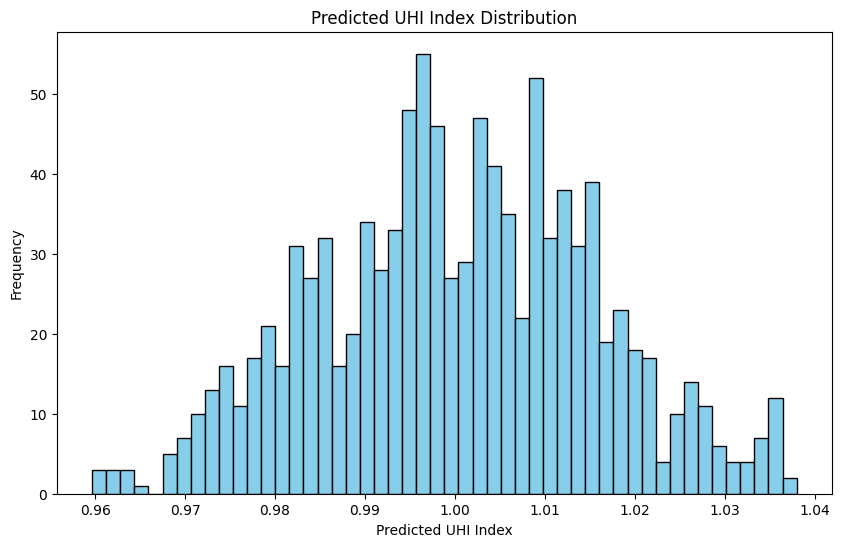

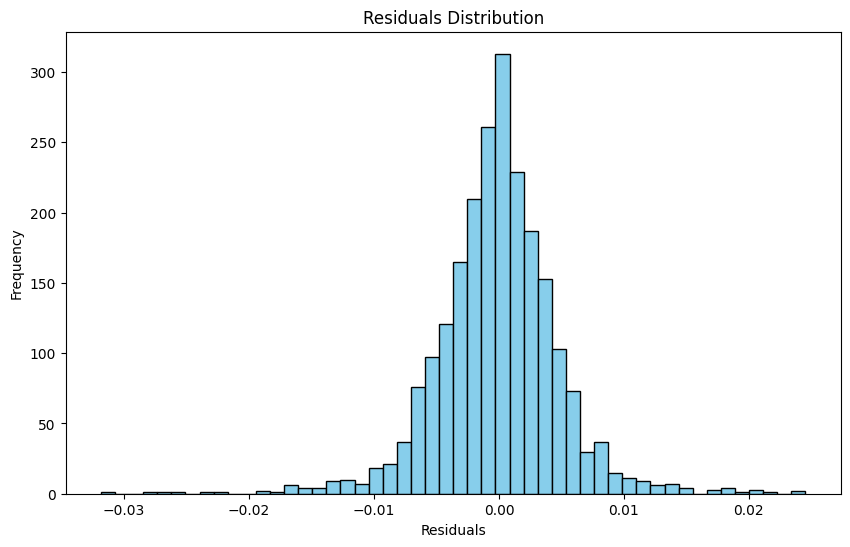

In [14]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.hist(submission_predictions, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Predicted UHI Index')
plt.ylabel('Frequency')
plt.title('Predicted UHI Index Distribution')
plt.show()

# Plot Residuals
plt.figure(figsize=(10, 6))
plt.hist(y_test - y_pred_lgb_best, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

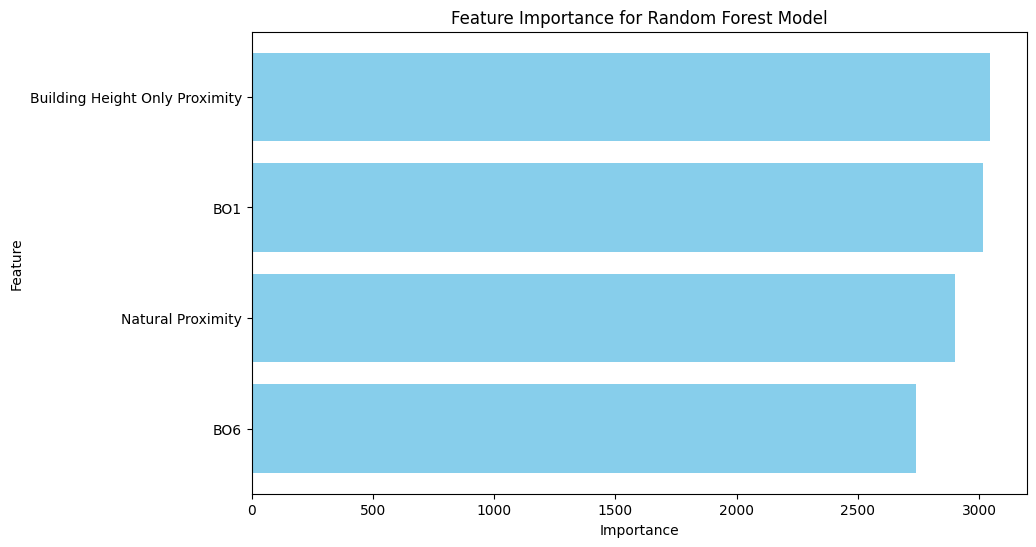

In [15]:
# Get feature importances
importances = lgb_model_best.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [16]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This was slightly worse than the other models at 0.917 using this technique. 

# Conclusion: